In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# PATHS
data_path = '../data/'
notebooks = '../notebooks/'
models = '../models/'

# DATASET
DATASET_COLUMNS = ["message", "class"]
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 50
EPOCHS = 20
BATCH_SIZE = 16

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = models + "model.h5"
WORD2VEC_MODEL = models + "model.w2v"
TOKENIZER_MODEL = models + "tokenizer.pkl"
ENCODER_MODEL = models + "encoder.pkl"

In [5]:
df = pd.read_csv(data_path + 'Train_Hate_All.csv')
df = df.rename(columns={'tweet': 'message', 'Hate_Speech': 'class'})
df = df.replace(0, -1)
df.head()

,message,class
0,"@RexHuppke Ah fuck him, sounds like he'll be d...",-1
1,@mariaaraujo98 @Val_Voshchevska @angelasingh24...,1
2,@GenePark @myhlee @PostBaron @mboorstein Don't...,-1
3,@peterbakernyt Sanders can choke on his dandruff.,-1
4,@realDonaldTrump @FoxNews Fox News aka the Tru...,-1


In [6]:
decode_map = {-1: "NEGATIVE", 0: "NEUTRAL", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df['class'] = df['class'].apply(lambda x: decode_sentiment(x))

In [7]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df.message = df.message.apply(lambda x: preprocess(x))

In [8]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11898
TEST size: 2975


In [9]:
documents = [_text.split() for _text in df_train.message] 
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
# words = w2v_model.wv.vocab.keys()
vocab_size = len(w2v_model.wv)
print("Vocab size", vocab_size)

2021-06-21 01:32:45,606 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-06-21T01:32:45.592684', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'created'}
2021-06-21 01:32:45,608 : INFO : collecting all words and their counts
2021-06-21 01:32:45,609 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-21 01:32:45,630 : INFO : PROGRESS: at sentence #10000, processed 74492 words, keeping 18836 word types
2021-06-21 01:32:45,635 : INFO : collected 21237 word types from a corpus of 88639 raw words and 11898 sentences
2021-06-21 01:32:45,635 : INFO : Creating a fresh vocabulary
2021-06-21 01:32:45,648 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1420 unique words (6.686443471300089%% of original 21237, drops 19817)', 'datetime': '2021-06-21T01:32:45.648473', 'gensim': '4.0

Vocab size 1420


In [10]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-06-21 01:32:45,692 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 1420 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-06-21T01:32:45.692271', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'train'}
2021-06-21 01:32:45,724 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 01:32:45,733 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 01:32:45,734 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 01:32:45,737 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 01:32:45,741 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 01:32:45,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 01:32:45,747 : INFO : worker thread finished; awaiting finish 

2021-06-21 01:32:46,206 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 01:32:46,207 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 01:32:46,208 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 01:32:46,209 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 01:32:46,210 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 01:32:46,211 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 01:32:46,212 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 01:32:46,213 : INFO : EPOCH - 10 : training on 88639 raw words (46362 effective words) took 0.0s, 1078206 effective words/s
2021-06-21 01:32:46,238 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 01:32:46,258 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 01:32:46,260 : INFO : worker thread

2021-06-21 01:32:46,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 01:32:46,657 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 01:32:46,657 : INFO : EPOCH - 19 : training on 88639 raw words (46369 effective words) took 0.0s, 1273245 effective words/s
2021-06-21 01:32:46,684 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 01:32:46,690 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 01:32:46,693 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 01:32:46,694 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 01:32:46,695 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 01:32:46,696 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 01:32:46,699 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 01:32:46,699 : INFO : worker thread

2021-06-21 01:32:47,118 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 01:32:47,118 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 01:32:47,120 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 01:32:47,120 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 01:32:47,122 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 01:32:47,122 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 01:32:47,123 : INFO : EPOCH - 29 : training on 88639 raw words (46334 effective words) took 0.0s, 1621893 effective words/s
2021-06-21 01:32:47,143 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 01:32:47,150 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 01:32:47,162 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 01:32:47,163 : INFO : worker thread

(1482344, 2836448)

In [11]:
w2v_model.wv.most_similar("hate")

[('filled', 0.772788405418396),
 ('violence', 0.7679764032363892),
 ('free', 0.7413351535797119),
 ('group', 0.7099680304527283),
 ('kidding', 0.6894503831863403),
 ('speech', 0.6736305952072144),
 ('promoting', 0.6541690826416016),
 ('spreading', 0.6492462158203125),
 ('spread', 0.6460229754447937),
 ('problem', 0.6403052806854248)]

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.message)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 21238


In [13]:
# min sample size
min_length = 1e10
for i in df['class'].unique().tolist():
    curr_length = len(df[df['class'] == i])
    if curr_length != 0 and curr_length < min_length:
        min_length = curr_length

# undersample
df_arr = []
for i in df['class'].unique().tolist():
    df_arr.append(df[df['class'] == i].sample(min_length))

df = pd.concat(df_arr)
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print(len(df))

1812


In [14]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.message), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.message), maxlen=SEQUENCE_LENGTH)

In [15]:
labels = df_train['class'].unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [16]:
encoder = LabelEncoder()
encoder.fit(df_train['class'].tolist())

y_train = encoder.transform(df_train['class'].tolist())
y_test = encoder.transform(df_test['class'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1449, 1)
y_test (363, 1)


In [17]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
print(vocab_size)
for word in w2v_model.wv.key_to_index:
    embedding_matrix[w2v_model.wv.key_to_index[word]] = w2v_model.wv[word]
print(embedding_matrix.shape)

21238
(21238, 100)


In [18]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [19]:
model = Sequential()
model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2123800   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,189,229
Trainable params: 65,429
Non-trainable params: 2,123,800
_________________________________________________________________


In [20]:
print(df.head())
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_auc', min_delta=1e-4, patience=5)]
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.25,
                    verbose=1,
                    callbacks=callbacks,
                    shuffle=True)

                                                 message     class
9389                         afp survives apostate islam  NEGATIVE
14231  hope someone like farrell made pro debut 17 ro...  NEGATIVE
4040   jaketapper well stay safe keep us posted okay ...  NEGATIVE
14240  understand jehovah witnesses vote serve absolu...  NEGATIVE
13814  nra bloomberg soros want disarm us mercy globa...  NEGATIVE
Epoch 1/20
68/68 [==============================] - 15s 11ms/step - loss: 0.7017 - auc: 0.5157 - val_loss: 0.6774 - val_auc: 0.6443
Epoch 2/20
68/68 [==============================] - 0s 4ms/step - loss: 0.6650 - auc: 0.6691 - val_loss: 0.6530 - val_auc: 0.6975
Epoch 3/20
68/68 [==============================] - 0s 4ms/step - loss: 0.6289 - auc: 0.7361 - val_loss: 0.6682 - val_auc: 0.7375
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.5582 - auc: 0.7889 - val_loss: 0.6128 - val_auc: 0.7428
Epoch 5/20
68/68 [==============================] - 0s 3ms/step - loss: 0.49

In [21]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

23/23 [==============================] - 0s 2ms/step - loss: 0.6265 - auc: 0.7232

ACCURACY: 0.7232218980789185
LOSS: 0.6264528632164001


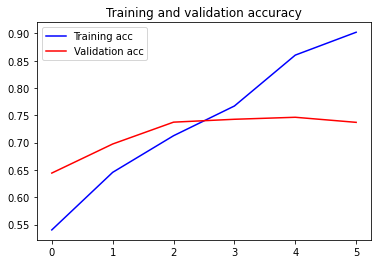

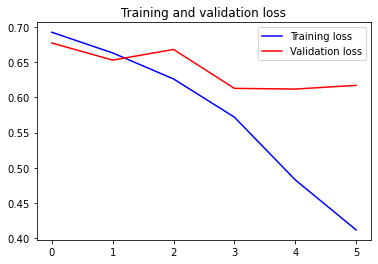

In [22]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [23]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [24]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [25]:
predict('I hate the weather')

{'label': 'NEGATIVE',
 'score': 0.3749382793903351,
 'elapsed_time': 0.27918314933776855}

In [26]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-06-21 01:33:04,500 : INFO : Word2Vec lifecycle event {'fname_or_handle': '../models/model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-06-21T01:33:04.500246', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'saving'}
2021-06-21 01:33:04,501 : INFO : not storing attribute cum_table
2021-06-21 01:33:04,504 : INFO : saved ../models/model.w2v
